# ASTR 19 Final Pt. 2 - f105w

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sep

In [2]:
from astropy.io import fits
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [3]:
#import fits data
hdu = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
hdu.info()

data_1 = hdu[0].data

hdu.close()
#print(type(data))

Filename: hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


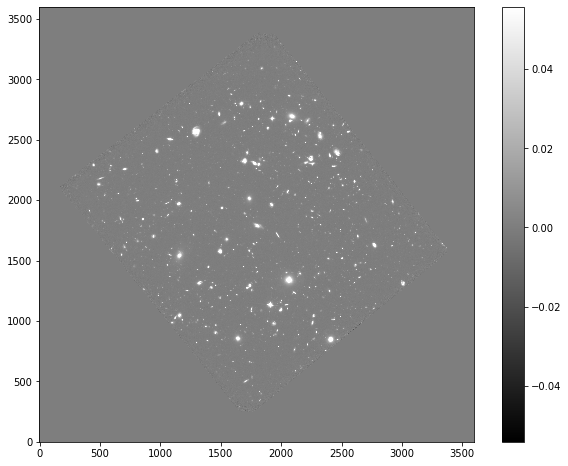

In [4]:
# show the image
data_1 = data_1.byteswap().newbyteorder()
m, s = np.mean(data_1), np.std(data_1)

plt.imshow(data_1, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig('f105w ini.pdf',bbox_inches='tight',pad_inches=0,dpi=300,)

Background subtraction

In [105]:
# measure a spatially varying background on the image
#data_1 = data_1.byteswap().newbyteorder()
bkg = sep.Background(data_1)

In [106]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [107]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

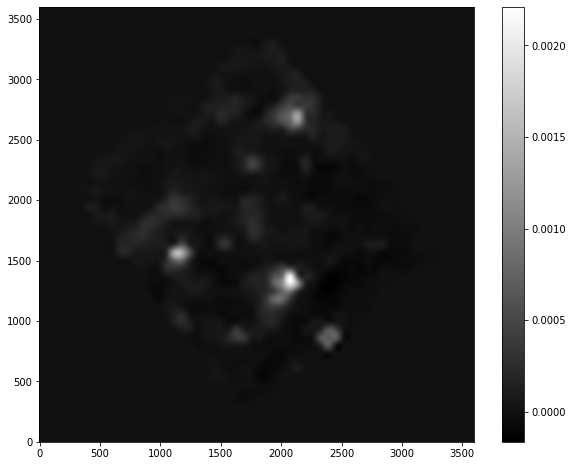

In [108]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('f105w background.pdf',bbox_inches='tight',pad_inches=0,dpi=300,)

In [109]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

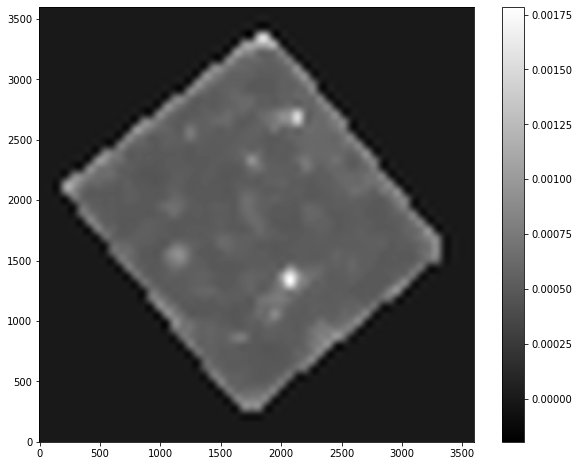

In [110]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('f105w background noise.pdf',bbox_inches='tight',pad_inches=0,dpi=300,)

In [111]:
# subtract the background
data_sub = data_1 - bkg

Object Detection

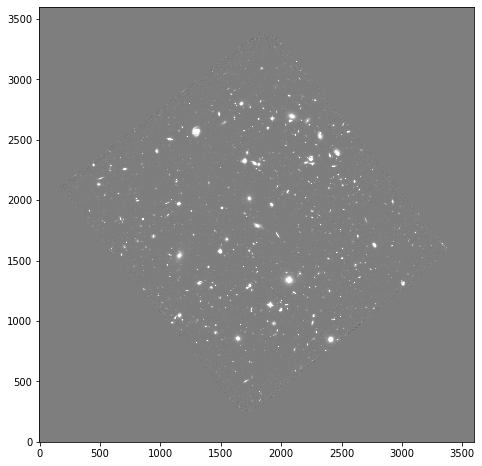

In [112]:
#from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

plt.savefig('f105w no ellipse plot.pdf',bbox_inches='tight',pad_inches=0,dpi=500,)

Spent some time playing and comparing the threshold value. After noticing there that at a lower threshold, the "noise vignette" found on the edges of the tilted square was confusing the sep.extraction function, that was thinking that grain and noise was actual objects. I changed the threshold from 1.5 to 6.5 which removes the majority of the noise objects while not removing too many faint objects. If this were a phototograph instead of raw data, the easy soloution would be to crop away the noise around the edge, and focus on the inner area of the image which incldues actual objects, not noise. 

In [113]:
# detect objects

#NOTE the 6.5 threshold
objects = sep.extract(data_sub, 6.5, err=bkg.globalrms)

# how many objects were detected
len(objects)

2122

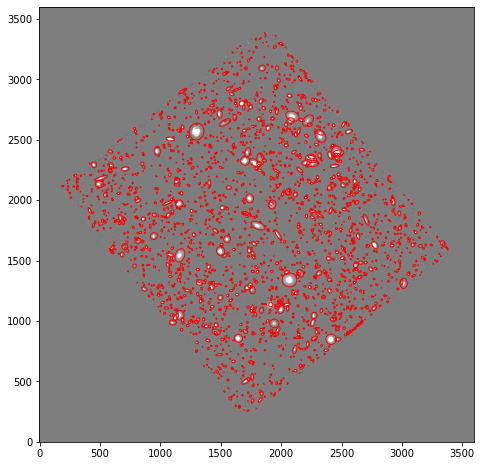

In [114]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=8*objects['a'][i],
                height=8*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('f105w final plot.pdf',bbox_inches='tight',pad_inches=0,dpi=500,)

In [53]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

Aperture photometry

In [54]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [59]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))
    
for i in range(10):
    print(flux[i], fluxerr[i])

object 0: flux = 0.079123 +/- 0.281302
object 1: flux = 0.103989 +/- 0.322486
object 2: flux = 0.068334 +/- 0.261423
object 3: flux = 0.065770 +/- 0.256473
object 4: flux = 0.142099 +/- 0.376971
object 5: flux = 1.153159 +/- 1.073856
object 6: flux = 0.148296 +/- 0.385103
object 7: flux = 0.138505 +/- 0.372174
object 8: flux = 0.108607 +/- 0.329568
object 9: flux = 0.085524 +/- 0.292459
0.079122745108034 0.2813023245089546
0.10398929537041114 0.32248645408387955
0.06833370844828665 0.26142295445196434
0.06576993773691359 0.25647259191387445
0.1420991408900591 0.376971312228862
1.1531591040641067 1.0738563071410077
0.1482958153483924 0.3851026720427938
0.138505209472005 0.37217398323152606
0.10860681516467593 0.32956800183085605
0.0855241989553906 0.29245935603791834


# Histogram the Fluxes:

In [72]:
print(f'{flux}')


[0.07912275 0.1039893  0.06833371 ... 0.06379297 0.05937629 0.08750513]


830.1552559661867


(0.0, 0.0025)

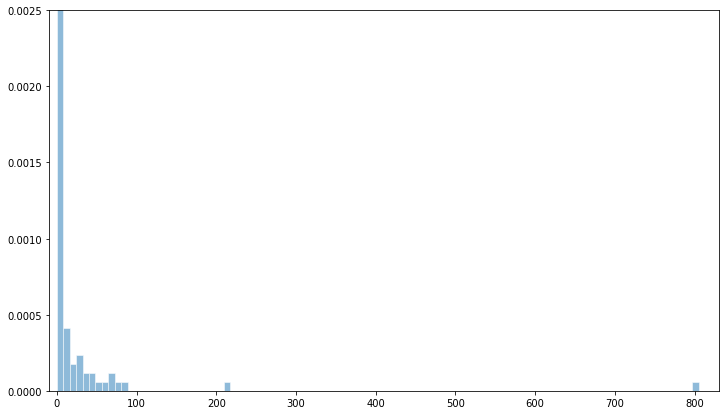

In [94]:
#for i in range()

f = plt.figure(figsize=(12,7))
amax = np.amax(flux) + 25
print(amax)

#range=(-1,100),

plt.hist(flux,bins=100, alpha=0.5, edgecolor="white",density=True)
plt.xlim([-10.05,amax])
plt.ylim([0., 0.0025])

While the y axis is missing for than 99% of the data, I squeezed the Y axis down to single digits such that you can visually see the not one, but "two" outliers. I have a feeling I know what they are. -+-

In [103]:
# finding the two local "mily way" stars with substantally 
#more "flux" value than the majority of the other objects in the HUDF.

#the threshold of 10,000 will shows us where those two outliers are.
objects = sep.extract(data_sub, 10000, err=bkg.globalrms)

# how many objects were detected
len(objects)

2

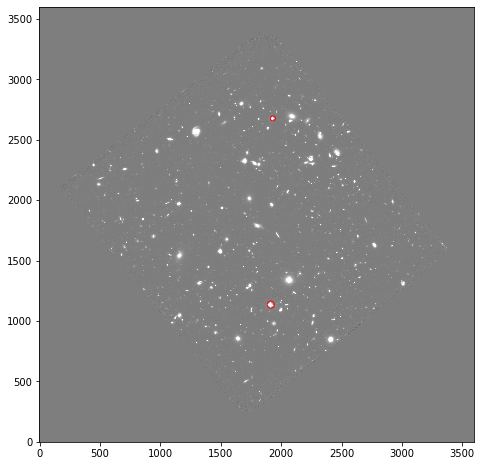

In [104]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=40*objects['a'][i],
                height=40*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('f105w final plot BRIGHT.pdf',bbox_inches='tight',pad_inches=0,dpi=500,)

^^^ There they are! I'm guessing there are dimmer milky way stars that are also visible, but not bright enough to create the classic hubble 90-degree cross hatch lines. In any case, that's where your two outliers are.

# HUDF 3 color image

In [115]:
from astropy.io import fits